In [2]:
# create a normal distribution
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div
from scipy.special import rel_entr
from scipy.stats import entropy
from scipy.stats import norm, uniform
from scipy.stats import gaussian_kde

import torch
from torch.nn.functional import softmax
from torch.nn.functional import log_softmax


(10, 2)


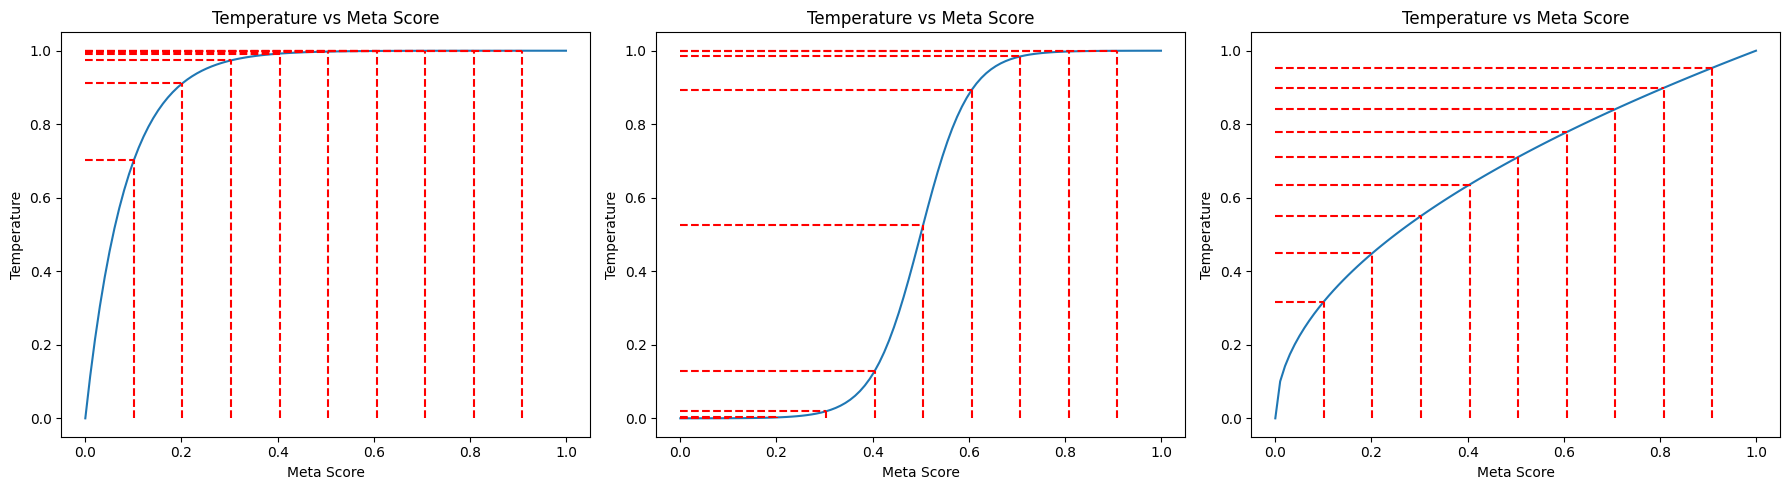

In [3]:
def exponential_bias(x, rate=4):
    return 1 - np.exp(-rate * x)

def logistic_bias(x, growth_rate=20, midpoint=0.5):
    return  1/ (1 + np.exp(-growth_rate * (x - midpoint)))

def polynomial_bias(x, power=0.5):
    return x ** power

def plot_temperature_vs_meta_score(ax, meta_score, temperature, title, xlabel, ylabel, highlight_points):
    ax.plot(meta_score, temperature)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # visiuale which values on the x-axis are mapped to which values on the y-axis
    for point in highlight_points:
        ax.plot([point[0], point[0]], [0, point[1]], 'r--')
        ax.plot([0, point[0]], [point[1], point[1]], 'r--')


meta_score = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(18, 5))

# exponential bias
rate = 5
temperature = exponential_bias(meta_score, rate)

num_cuts = 10
highlight_points = meta_score[::num_cuts]
mapped_points = exponential_bias(highlight_points, rate)
# merge to points
highlight_points = np.vstack((highlight_points, mapped_points)).T
print(highlight_points.shape)

ax1 = fig.add_subplot(1, 3, 1)
plot_temperature_vs_meta_score(ax1, meta_score, temperature, 'Temperature vs Meta Score', 'Meta Score', 'Temperature', highlight_points)

# logistic bias
growth_rate = 20
midpoint = 0.5
temperature = logistic_bias(meta_score, growth_rate, midpoint)

num_cuts = 10
highlight_points = meta_score[::num_cuts]
mapped_points = logistic_bias(highlight_points, growth_rate, midpoint)
highlight_points = np.vstack((highlight_points, mapped_points)).T

ax2 = fig.add_subplot(1, 3, 2)
plot_temperature_vs_meta_score(ax2, meta_score, temperature, 'Temperature vs Meta Score', 'Meta Score', 'Temperature', highlight_points)

# polynomial bias
power = 0.5
temperature = polynomial_bias(meta_score, power)

num_cuts = 10
highlight_points = meta_score[::num_cuts]
mapped_points = polynomial_bias(highlight_points, power)
highlight_points = np.vstack((highlight_points, mapped_points)).T

ax3 = fig.add_subplot(1, 3, 3)
plot_temperature_vs_meta_score(ax3, meta_score, temperature, 'Temperature vs Meta Score', 'Meta Score', 'Temperature', highlight_points)

plt.tight_layout()
plt.show()


KL divergence:  22.649298229831153
JS distance:  0.813380521235197
JS divergence:  0.6615878723248407


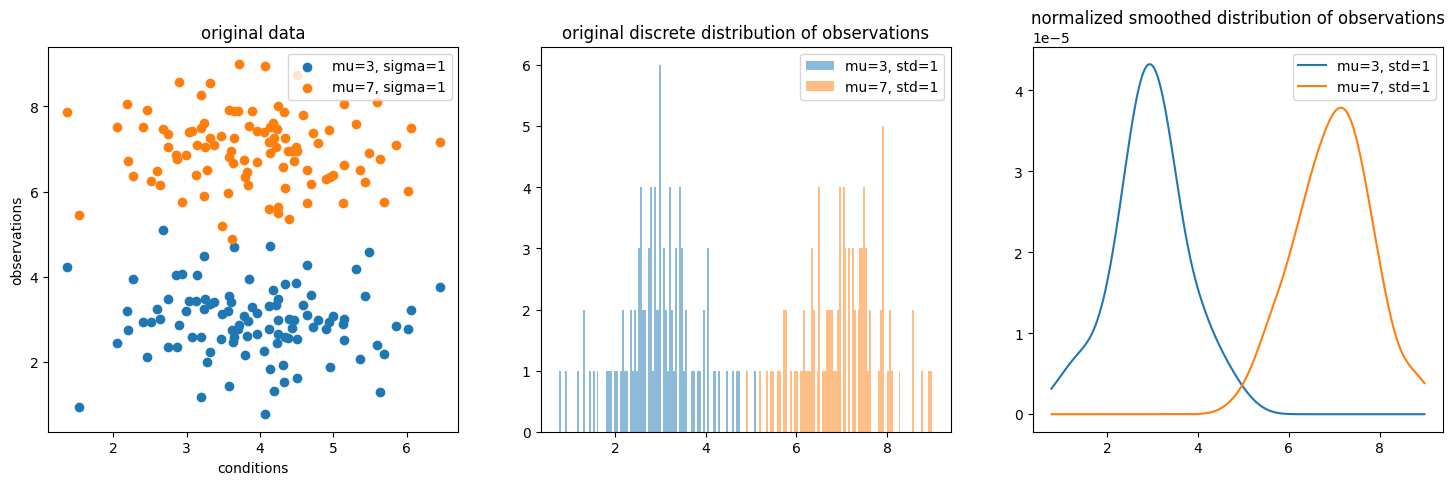

KL divergence:  0.12499999997582195
JS distance:  0.1741014087052879
JS divergence:  0.030311300513165697


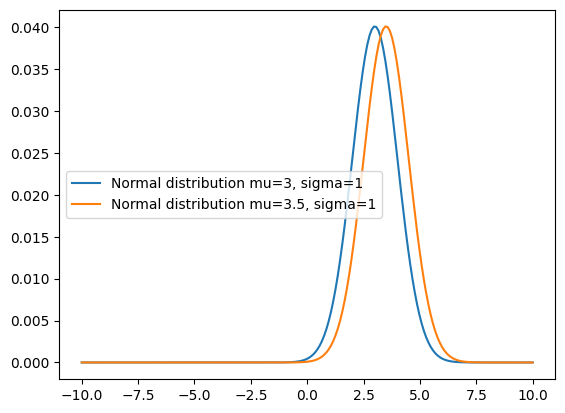

In [4]:
size = 100
conditions = np.random.normal(loc=4, scale=1, size=(size,))

mu_1, sigma_1 = 3, 1
mu_2, sigma_2 = 7, 1
# mu_2, sigma_2 = 10000000, 1

observations_1 = np.random.normal(loc=mu_1, scale=sigma_1, size=(size,))
observations_2 = np.random.normal(loc=mu_2, scale=sigma_2, size=(size,))

# plot the data
fig = plt.figure(figsize=(18, 5))
ax_1 = plt.subplot(1, 3, 1)
ax_1.scatter(conditions, observations_1, label=f"mu={mu_1}, sigma={sigma_1}")
ax_1.scatter(conditions, observations_2, label=f"mu={mu_2}, sigma={sigma_2}")
ax_1.set_title('original data')
ax_1.set_xlabel('conditions')
ax_1.set_ylabel('observations')
ax_1.legend()

sorted_observations_1 = np.sort(observations_1)
sorted_observations_2 = np.sort(observations_2)
smoothed_observations_1 = gaussian_kde(sorted_observations_1)
smoothed_observations_2 = gaussian_kde(sorted_observations_2)

min_observation = np.min([np.min(sorted_observations_1), np.min(sorted_observations_2)])
max_observation = np.max([np.max(sorted_observations_1), np.max(sorted_observations_2)])
shared_x = np.linspace(
    min_observation,
    max_observation,
    100000,
)
smoothed_distribution_1 = smoothed_observations_1(shared_x)
smoothed_distribution_2 = smoothed_observations_2(shared_x)

# normalized_distribution_1 = softmax(torch.tensor(smoothed_distribution_1, dtype=torch.float32), dim=0).numpy()
# normalized_distribution_2 = softmax(torch.tensor(smoothed_distribution_2, dtype=torch.float32), dim=0).numpy()
normalized_distribution_1 = smoothed_distribution_1 / np.sum(smoothed_distribution_1)
normalized_distribution_2 = smoothed_distribution_2 / np.sum(smoothed_distribution_2)

# calculate the KL and jensen shannon divergence between the two distributions
kl_divergence = np.sum(kl_div(normalized_distribution_1, normalized_distribution_2))
js_distance = jensenshannon(normalized_distribution_1, normalized_distribution_2)
js_divergence = jensenshannon(normalized_distribution_1, normalized_distribution_2) ** 2

print("KL divergence: ", kl_divergence)
print("JS distance: ", js_distance)
print("JS divergence: ", js_divergence)

ax_2 = plt.subplot(1, 3, 2)
# plot a histogram of the observations
ax_2.hist(observations_1, bins=100, alpha=0.5, label=f"mu={mu_1}, std={sigma_1}")
ax_2.hist(observations_2, bins=100, alpha=0.5, label=f"mu={mu_2}, std={sigma_2}")
ax_2.set_title('original discrete distribution of observations')
ax_2.legend()

ax_3 = plt.subplot(1, 3, 3)
# plot the normalized distributions of the observations
ax_3.plot(shared_x, normalized_distribution_1, label=f"mu={mu_1}, std={sigma_1}")
ax_3.plot(shared_x, normalized_distribution_2, label=f"mu={mu_2}, std={sigma_2}")
ax_3.set_title('normalized smoothed distribution of observations')
ax_3.legend()
plt.show()


# same with a direct normal distribution
x = np.linspace(-10, 10, 200)
mu_1, sigma_1 = 3, 1
mu_2, sigma_2 = 3.5, 1
y_1 = norm.pdf(x, mu_1, sigma_1)
y_2 = norm.pdf(x, mu_2, sigma_2)

# normalized_y_1 = softmax(torch.tensor(y_1, dtype=torch.float32), dim=0).numpy()
# normalized_y_2 = softmax(torch.tensor(y_2, dtype=torch.float32), dim=0).numpy()
normalized_y_1 = y_1 / np.sum(y_1)
normalized_y_2 = y_2 / np.sum(y_2)

# calculate the KL divergence between the two distributions
kl_divergence = np.sum(kl_div(normalized_y_1, normalized_y_2))
js_distance = jensenshannon(normalized_y_1, normalized_y_2)
js_divergence = jensenshannon(normalized_y_1, normalized_y_2) ** 2
print("KL divergence: ", kl_divergence)
print("JS distance: ", js_distance)
print("JS divergence: ", js_divergence)

plt.plot(x, normalized_y_1, label=f"Normal distribution mu={mu_1}, sigma={sigma_1}")
plt.plot(x, normalized_y_2, label=f"Normal distribution mu={mu_2}, sigma={sigma_2}")
plt.legend()
plt.show()
